# Fraud Detection in Crypto (ETH Blockchain)  
Dataset Link: https://www.kaggle.com/datasets/vagifa/ethereum-frauddetection-dataset/code

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

## Data Collection

In [2]:
pd.set_option('display.max_columns', None)

df = pd.read_csv('transaction_dataset.csv')

df = df.iloc[:,1:]
df.head()

,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,total ether balance,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 avg time between sent tnx,ERC20 avg time between rec tnx,ERC20 avg time between rec 2 tnx,ERC20 avg time between contract tnx,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,45.806785,6.589513,0.00,31.220000,1.200681,0.0,0.0,0.0,810,865.691093,586.466675,0.0,-279.224419,265.0,3.558854e+07,3.560317e+07,0.0,30.0,54.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,1.500000e+07,265586.147600,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,2.613269,0.385685,0.00,1.800000,0.032844,0.0,0.0,0.0,102,3.087297,3.085478,0.0,-0.001819,8.0,4.034283e+02,2.260809e+00,0.0,1.0,5.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,3.650000e+02,57.632615,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,1.165453,0.358906,0.05,3.538616,1.794308,0.0,0.0,0.0,12,3.588616,3.589057,0.0,0.000441,8.0,5.215121e+02,0.000000e+00,0.0,0.0,7.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,4.428198e+02,65.189009,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,500.000000,99.488840,0.00,450.000000,70.001834,0.0,0.0,0.0,34,1750.045862,895.399559,0.0,-854.646303,14.0,1.711105e+04,1.141223e+04,0.0,2.0,11.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,1.141223e+04,1555.550174,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,12.802411,2.671095,0.00,9.000000,0.022688,0.0,0.0,0.0,4619,104.318883,53.421897,0.0,-50.896986,42.0,1.628297e+05,1.235399e+05,0.0,4.0,23.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,9.000000e+04,4934.232147,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


## Data Cleaning

In [3]:
round(df.describe(),2)

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,total ether balance,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 avg time between sent tnx,ERC20 avg time between rec tnx,ERC20 avg time between rec 2 tnx,ERC20 avg time between contract tnx,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
count,9841.00,9841.00,9841.00,9841.00,9841.00,9841.00,9841.00,9841.00,9841.00,9841.00,9841.00,9841.00,9841.00,9841.00,9841.00,9841.00,9841.00,9841.00,9841.00,9841.00,9841.00,9841.00,9841.00,9012.00,9.012000e+03,9.012000e+03,9012.00,9012.00,9012.00,9012.00,9012.00,9012.0,9012.0,9012.0,9012.0,9012.00,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9012.0,9012.0,9012.0,9012.00,9012.00
mean,0.22,5086.88,8004.85,218333.26,115.93,163.70,3.73,30.36,25.84,43.85,523.15,100.71,4.80,314.62,44.76,0.00,0.00,0.00,283.36,10160.92,11638.32,0.00,1477.40,36.26,1.296207e+08,1.386849e+07,110.94,5.64,7.60,0.00,4.90,0.0,0.0,0.0,0.0,485.61,1.252524e+08,4.346203e+06,1.174126e+04,1.303594e+07,6.318389e+06,0.0,0.0,0.0,1.38,4.83
std,0.42,21486.55,23081.71,322937.93,757.23,940.84,141.45,298.62,263.82,325.93,13008.82,2885.00,138.61,6629.21,239.08,0.00,0.00,0.00,1352.40,358322.71,364204.77,0.00,242425.42,447.53,1.053858e+10,1.180390e+09,6128.63,105.25,81.82,0.07,17.25,0.0,0.0,0.0,0.0,16883.28,1.053741e+10,2.141192e+08,1.053567e+06,1.179905e+09,5.914764e+08,0.0,0.0,0.0,6.74,16.68
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-15605352.04,0.00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.00,0.00
25%,0.00,0.00,0.00,316.93,1.00,1.00,0.00,1.00,1.00,0.00,1.00,0.43,0.00,0.16,0.09,0.00,0.00,0.00,4.00,0.23,2.67,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.00,0.00
50%,0.00,17.34,509.77,46637.03,3.00,4.00,0.00,2.00,2.00,0.10,6.00,1.73,0.05,5.00,1.61,0.00,0.00,0.00,8.00,12.49,30.53,0.00,0.00,1.00,0.000000e+00,0.000000e+00,0.00,0.00,1.00,0.00,1.00,0.0,0.0,0.0,0.0,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.00,1.00
75%,0.00,565.47,5480.39,304070.98,11.00,27.00,0.00,5.00,3.00,2.00,67.07,22.00,1.00,61.52,22.00,0.00,0.00,0.00,54.00,101.00,101.00,0.00,0.04,3.00,1.003400e+02,0.000000e+00,0.00,0.00,2.00,0.00,2.00,0.0,0.0,0.0,0.0,0.00,9.900000e+01,2.946000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.00,2.00
max,1.00,430287.67,482175.49,1954860.95,10000.00,10000.00,9995.00,9999.00,9287.00,10000.00,800000.00,283618.83,12000.00,520000.00,12000.00,0.02,0.05,0.02,19995.00,28580960.89,28581590.07,0.05,14288636.26,10001.00,1.000020e+12,1.120000e+11,416000.00,6582.00,4293.00,3.00,782.00,0.0,0.0,0.0,0.0,990000.00,1.000000e+12,1.724181e+10,1.000000e+08,1.120000e+11,5.614756e+10,0.0,0.0,0.0,213.00,737.00


In [4]:
#Check duplicated
duplicate_address = df['Address'].value_counts()[df['Address'].value_counts() > 1]
print(f"Count of duplicated address rows: {duplicate_address.count()}")
#print("\n")
print(duplicate_address)


Count of duplicated address rows: 25
Address
0x4cd526aa2db72eb1fd557b37c6b0394acd35b212    2
0x4cd3bb2110eda1805dc63abc1959a5ee2d386e9f    2
0x4c1da8781f6ca312bc11217b3f61e5dfdf428de1    2
0x4c24af967901ec87a6644eb1ef42b680f58e67f5    2
0x4c268c7b1d51b369153d6f1f28c61b15f0e17746    2
0x4c26a3c12a64f33a3546fbb206c5365ce8e82c20    2
0x4c271764eadcf0d07e5a937b2de290294c9d11c2    2
0x4c27438a77738153f6cf3ed890b2817d52ebf584    2
0x4c391cc032c9107b596267610a05262c90fc2df7    2
0x4c4a03e100b4b104355edc4c50ce12b9a2879547    2
0x4c4da560350e302232a184c8fa16b126a772c326    2
0x4c5b0709f66719861e7277c9dcda9175deb3d866    2
0x4c7520df888aa4569a37ac7d132f89c65821f0af    2
0x4c77f6b01da78d053d5885e43bce5239b623dd3e    2
0x4c7accc2689708892be29256fbe9d45a92f0aa97    2
0x4c7f6d5b287054bf41f9d49ea8d2ca6e6837850b    2
0x4c97ccdaa61ca167e8a3b4d425ae6fbf16bcb39c    2
0x4cad652b71519a7a68d05dada31122c4c9a5ed95    2
0x4cb6f8f060365dd2e4eb949609dd6293bb950ae2    2
0x4cb981a7a2956cdfa8afbf454cb4e1b13c69aeb9 

In [5]:
#Check duplicated rows
df.loc[df['Address'] == '0x4cce03d1fd8aa1d6172cec74d75bd1df9e6a8ac2']

,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,total ether balance,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 avg time between sent tnx,ERC20 avg time between rec tnx,ERC20 avg time between rec 2 tnx,ERC20 avg time between contract tnx,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
2929,0x4cce03d1fd8aa1d6172cec74d75bd1df9e6a8ac2,0,0.0,0.0,89.1,1,1,0,1,1,1.015082,1.015082,1.015082,1.012037,1.012037,1.012037,0.0,0.0,0.0,2,1.012037,1.015082,0.0,0.003044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2954,0x4cce03d1fd8aa1d6172cec74d75bd1df9e6a8ac2,0,0.0,0.0,89.1,1,1,0,1,1,1.015082,1.015082,1.015082,1.012037,1.012037,1.012037,0.0,0.0,0.0,2,1.012037,1.015082,0.0,0.003044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [6]:
#Drop Duplicate Addresses
df = df.drop_duplicates(subset='Address', keep='first')
df.shape

(9816, 49)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9816 entries, 0 to 9840
Data columns (total 49 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Address                                               9816 non-null   object 
 1   FLAG                                                  9816 non-null   int64  
 2   Avg min between sent tnx                              9816 non-null   float64
 3   Avg min between received tnx                          9816 non-null   float64
 4   Time Diff between first and last (Mins)               9816 non-null   float64
 5   Sent tnx                                              9816 non-null   int64  
 6   Received Tnx                                          9816 non-null   int64  
 7   Number of Created Contracts                           9816 non-null   int64  
 8   Unique Received From Addresses                        9816 non-

In [8]:
# Check missing value
df.isna().sum()

Address                                                    0
FLAG                                                       0
Avg min between sent tnx                                   0
Avg min between received tnx                               0
Time Diff between first and last (Mins)                    0
Sent tnx                                                   0
Received Tnx                                               0
Number of Created Contracts                                0
Unique Received From Addresses                             0
Unique Sent To Addresses                                   0
min value received                                         0
max value received                                         0
avg val received                                           0
min val sent                                               0
max val sent                                               0
avg val sent                                               0
min value sent to contra

I reviewed several wallets with missing values and found no matching entries in the ERC-20 token transfer records. Based on this observation, I assumed these wallets had no ERC-20 activity and decided to impute all ERC-20–related columns with 0 to reflect the absence of transfers.

In [9]:
# Fill missing value with 0
df.fillna(0, inplace=True)

In [36]:
def cor_matrix(data):
    # Compute the correlation matrix of numeric columns
    corr = data.select_dtypes(include='number').corr()

    # Create mask to hide upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up matplotlib figure
    plt.figure(figsize=(15,15))

    # Customize seaborn heatmap
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', mask=mask, cbar_kws={'shrink':0.8})

    # Rotate x-axis labels
    plt.xticks(rotation=80)

    # Set plot title
    plt.title("Correlation Matrix", fontsize=20)

    plt.show()

In [11]:
def corelated(data, target_col, threshold):
    """
    Finds columns in `data` with correlation >= threshold (absolute) with the target column.

    Parameters:
    - data: pandas DataFrame
    - target_col: string, name of the column to compare against
    - threshold: float, minimum absolute correlation to include

    Returns:
    - pandas Series: correlation values sorted by strength
    """
    # Select numeric columns only
    numeric_data = data.select_dtypes(include='number')

    # Check if the target column is numeric and in the DataFrame
    if target_col not in numeric_data.columns:
        raise ValueError(f"'{target_col}' must be a numeric column in the DataFrame")

    # Compute correlation with target column
    corrs = numeric_data.corrwith(numeric_data[target_col])

    # Filter based on threshold
    result = corrs[abs(corrs) >= threshold].drop(labels=[target_col])

    return result.sort_values(ascending=False)

In [12]:
def get_high_corr_pairs(df, threshold=0.5):
    # Only use numeric columns
    corr_matrix = df.select_dtypes(include='number').corr()

    # Unstack the matrix to get pairs
    corr_unstacked = corr_matrix.abs().unstack()

    # Filter pairs above threshold but remove self-correlation (value = 1)
    high_corr_pairs = corr_unstacked[
        (corr_unstacked > threshold) & (corr_unstacked < 1)
    ].drop_duplicates()

    return high_corr_pairs.sort_values(ascending=False)


In [13]:
corelated(df, 'FLAG', 0.05)

/Users/duyenle/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/duyenle/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


 ERC20 uniq rec contract addr                          -0.061890
 ERC20 uniq rec token name                             -0.062344
avg val sent                                           -0.063355
Sent tnx                                               -0.078190
Received Tnx                                           -0.079536
total transactions (including tnx to create contract   -0.100551
Avg min between received tnx                           -0.118640
Time Diff between first and last (Mins)                -0.269612
dtype: float64

In [14]:
get_high_corr_pairs(df)

max val sent to contract        total ether sent contracts                              1.000000
 ERC20 total Ether received      ERC20 max val rec                                      0.999967
 ERC20 max val sent              ERC20 avg val sent                                     0.999952
 ERC20 min val sent              ERC20 avg val sent                                     0.999785
                                 ERC20 max val sent                                     0.999729
 ERC20 total ether sent          ERC20 max val sent                                     0.999649
 ERC20 uniq rec contract addr    ERC20 uniq rec token name                              0.999643
 ERC20 total ether sent          ERC20 avg val sent                                     0.999566
                                 ERC20 min val sent                                     0.999311
avg value sent to contract      total ether sent contracts                              0.949608
max val sent to contract      

In [15]:
def drop_highly_correlated_features(df, threshold=0.8):
    # Step 1: Compute correlation matrix (absolute values)
    corr_matrix = df.select_dtypes(include='number').corr().abs()

    # Step 2: Get upper triangle of the matrix (no duplicates or self-correlations)
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    # Step 3: Find pairs above threshold
    to_drop = set()
    for col in upper.columns:
        for row in upper.index:
            if upper.loc[row, col] > threshold:
                # Drop col if not already dropped; otherwise skip
                if col not in to_drop and row not in to_drop:
                    to_drop.add(col)

    # Step 4: Drop selected columns
    reduced_df = df.drop(columns=to_drop)

    return reduced_df, list(to_drop)

## ML models Comparision

In [16]:
from pycaret.classification import *

In [17]:
setup(df,target="FLAG",session_id=85)

,Description,Value
0,Session id,85
1,Target,FLAG
2,Target type,Binary
3,Original data shape,"(9816, 49)"
4,Transformed data shape,"(9816, 49)"
5,Transformed train set shape,"(6871, 49)"
6,Transformed test set shape,"(2945, 49)"
7,Numeric features,45
8,Categorical features,3
9,Preprocess,True


In [18]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.8948,0.9071,0.7148,0.7916,0.7506,0.6842,0.6861,0.0400
et,Extra Trees Classifier,0.8593,0.9950,0.3660,1.0000,0.5061,0.4554,0.5352,0.0440
rf,Random Forest Classifier,0.8422,0.9979,0.2892,1.0000,0.4383,0.3815,0.4834,0.0790
lr,Logistic Regression,0.8076,0.7762,0.1443,0.9390,0.2481,0.2013,0.3207,0.3090
dt,Decision Tree Classifier,0.7781,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0210
ada,Ada Boost Classifier,0.7781,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0210
gbc,Gradient Boosting Classifier,0.7781,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1720
lda,Linear Discriminant Analysis,0.7781,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0210
xgboost,Extreme Gradient Boosting,0.7781,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0360
lightgbm,Light Gradient Boosting Machine,0.7781,0.5446,0.0000,0.0000,0.0000,0.0000,0.0000,0.0770


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

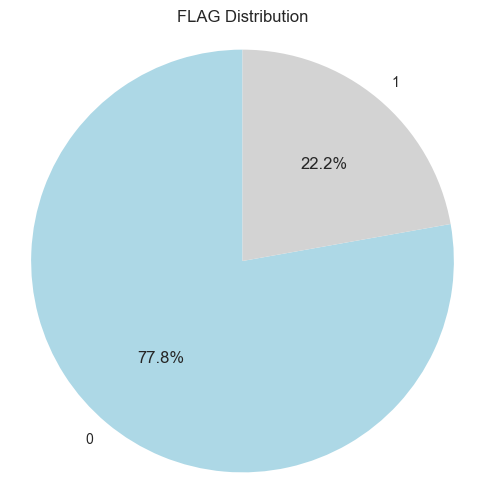

In [19]:
# Check FLAG
flag_counts = df['FLAG'].value_counts()

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(
    flag_counts, 
    labels=flag_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['lightblue','lightgrey']
)
plt.title('FLAG Distribution')
plt.axis('equal')  # Equal aspect ratio ensures circle shape
plt.show()

Class 1 represents the minority class (~22%), which could lead the model to favor predicting Class 0. To address this imbalance, SMOTE (Synthetic Minority Over-sampling Technique) should be applied to resample the training data and ensure better representation of the minority class during model learning.

In [20]:
check = df.iloc[:,1:].select_dtypes(include = ['number'])
no_var = check.var() == 0 
zero_var_cols = check.columns[no_var]

In [21]:
#Drop features with Variance = 0
data = df.drop(columns = zero_var_cols)
data.shape

(9816, 42)

In [22]:
data_, dropped_cols = drop_highly_correlated_features(data, threshold=0.7)
data_.shape

(9816, 29)

In [23]:
num_data = data_.select_dtypes(include = ['number'])
num_data.head()

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,max val sent to contract,total Ether sent,total ether balance,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 min val rec
0,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,...,0.0,865.691093,-279.224419,265.0,3.558854e+07,3.560317e+07,0.0,0.0,58.0,0.0
1,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,...,0.0,3.087297,-0.001819,8.0,4.034283e+02,2.260809e+00,0.0,0.0,7.0,0.0
2,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,...,0.0,3.588616,0.000441,8.0,5.215121e+02,0.000000e+00,0.0,0.0,8.0,0.0
3,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,...,0.0,1750.045862,-854.646303,14.0,1.711105e+04,1.141223e+04,0.0,0.0,11.0,0.0
4,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,...,0.0,104.318883,-50.896986,42.0,1.628297e+05,1.235399e+05,0.0,0.0,27.0,0.0


In [24]:
# Drop features that have mostly 0s
drop = []
for i in num_data.columns[1:]:
    if len(num_data[i].value_counts()) < 10:
        drop.append(i)
        print(df[i].value_counts())
        print('------------------')

min value sent to contract
0.00    9814
0.02       1
0.01       1
Name: count, dtype: int64
------------------
max val sent to contract
0.000000    9813
0.020000       1
0.010000       1
0.046029       1
Name: count, dtype: int64
------------------
 ERC20 uniq sent addr.1
0.0    9788
1.0      26
3.0       1
2.0       1
Name: count, dtype: int64
------------------


In [25]:
num_data.drop(columns=drop, inplace = True)
feature = num_data.columns[1:]
print(feature)

Index(['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'Unique Received From Addresses',
       'Unique Sent To Addresses', 'min value received', 'max value received ',
       'avg val received', 'min val sent', 'max val sent', 'avg val sent',
       'total Ether sent', 'total ether balance', ' Total ERC20 tnxs',
       ' ERC20 total Ether received', ' ERC20 total ether sent',
       ' ERC20 total Ether sent contract', ' ERC20 uniq rec contract addr',
       ' ERC20 min val rec'],
      dtype='object')


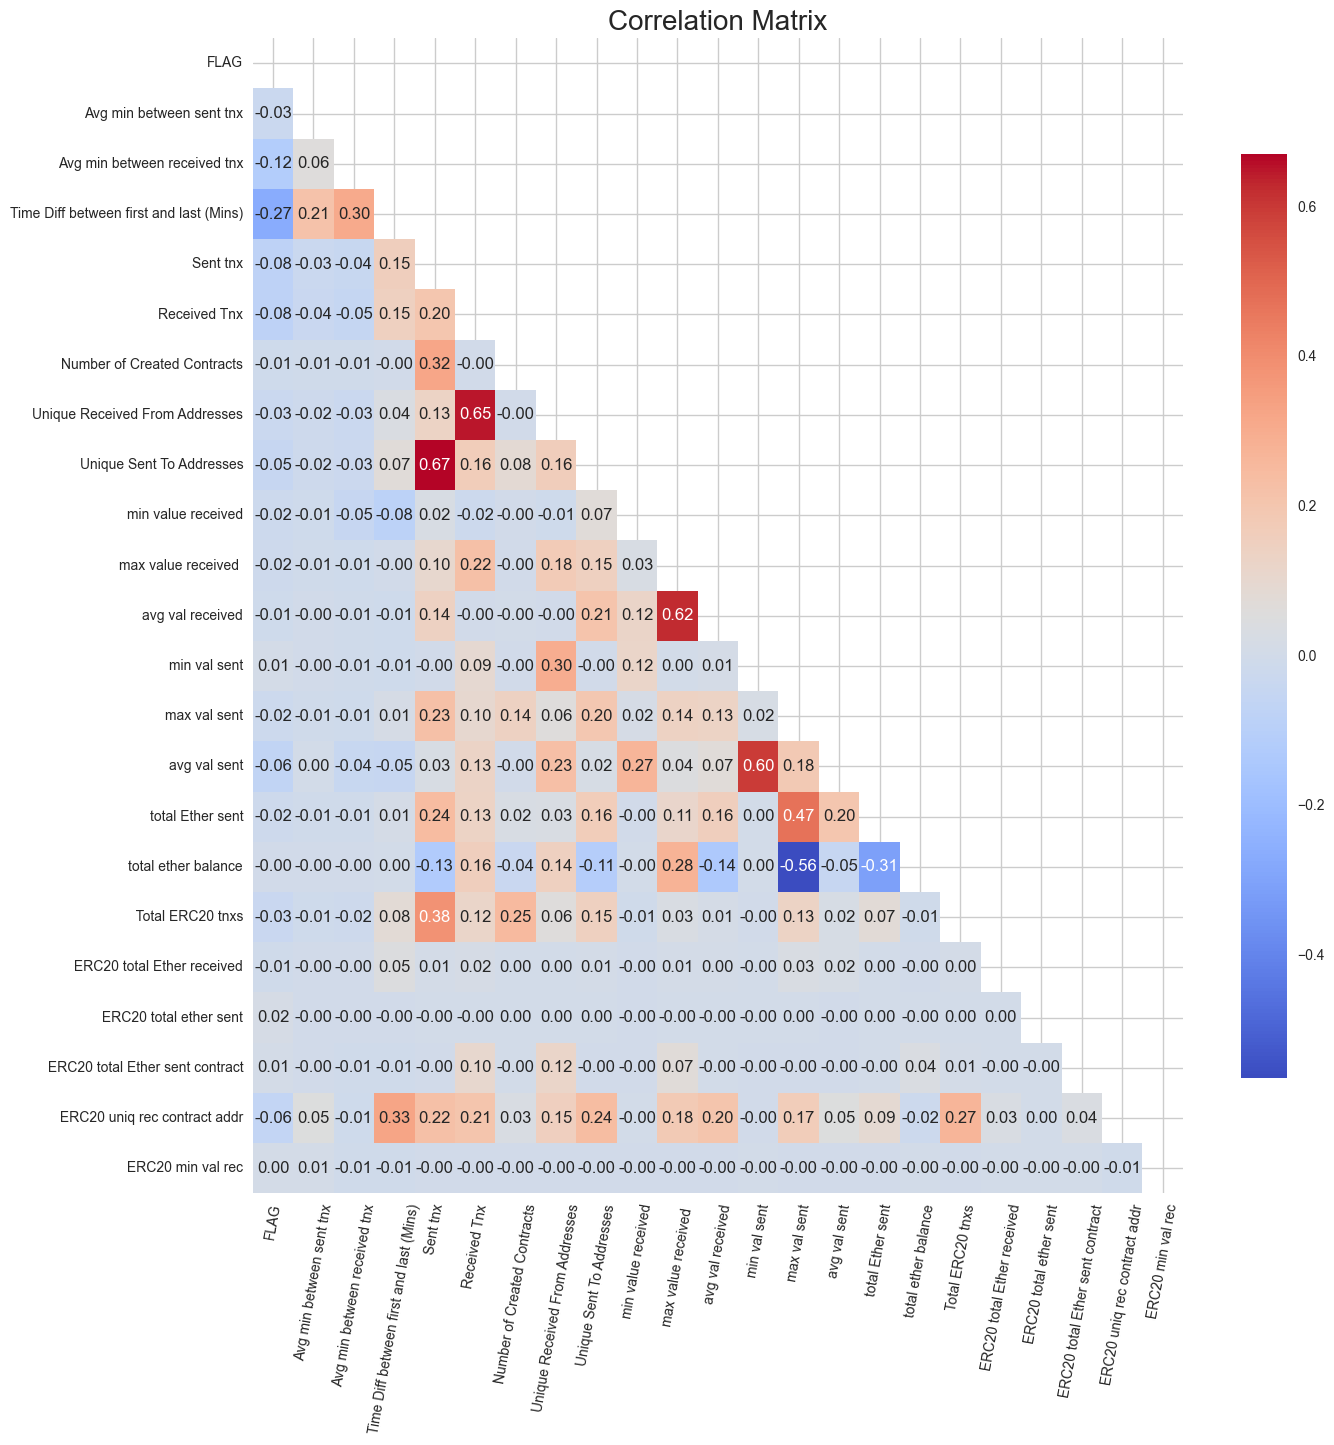

In [37]:
cor_matrix(num_data)

## Predictive Model

In [26]:
X = num_data[feature]
y = num_data['FLAG']

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


def model(X, y, pipeline):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    print(classification_report(y_test,y_pred))


    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion Matrix: \n{cm}')
    print('\n')

    # Predict on training data
    y_train_pred = pipeline.predict(X_train)

    # Accuracy scores
    print(f"Training accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Test accuracy:     {accuracy_score(y_test, y_pred):.4f}")

    #Predict probabilities
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="red")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend(loc = 'lower right')
    plt.show()

### KNN

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1528
           1       0.75      0.86      0.80       436

    accuracy                           0.91      1964
   macro avg       0.85      0.89      0.87      1964
weighted avg       0.91      0.91      0.91      1964

Confusion Matrix: 
[[1404  124]
 [  61  375]]


Training accuracy: 0.9312
Test accuracy:     0.9058


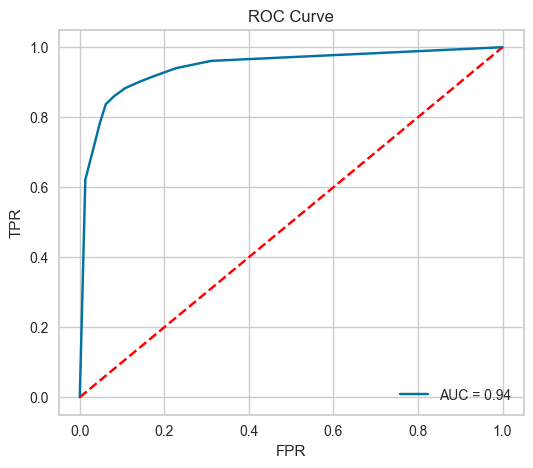

In [28]:
from sklearn.neighbors import KNeighborsClassifier

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=10))
])

model(X,y,pipeline)

### Logistic Regression

              precision    recall  f1-score   support

           0       0.93      0.53      0.68      1528
           1       0.34      0.86      0.49       436

    accuracy                           0.60      1964
   macro avg       0.64      0.69      0.58      1964
weighted avg       0.80      0.60      0.63      1964

Confusion Matrix: 
[[811 717]
 [ 63 373]]


Training accuracy: 0.6296
Test accuracy:     0.6029


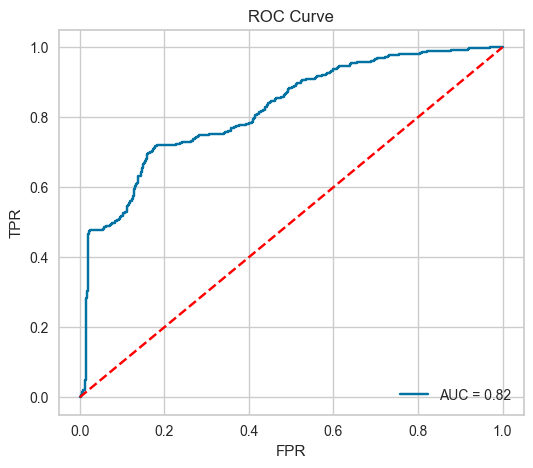

In [29]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([('smote', SMOTE(random_state=42)),
                     ('scaler', StandardScaler()),
                     ('lr', LogisticRegression(max_iter=1000))])

model(X,y,pipeline)

### Random Forest

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1528
           1       0.91      0.87      0.89       436

    accuracy                           0.95      1964
   macro avg       0.94      0.92      0.93      1964
weighted avg       0.95      0.95      0.95      1964

Confusion Matrix: 
[[1491   37]
 [  57  379]]


Training accuracy: 0.9997
Test accuracy:     0.9521


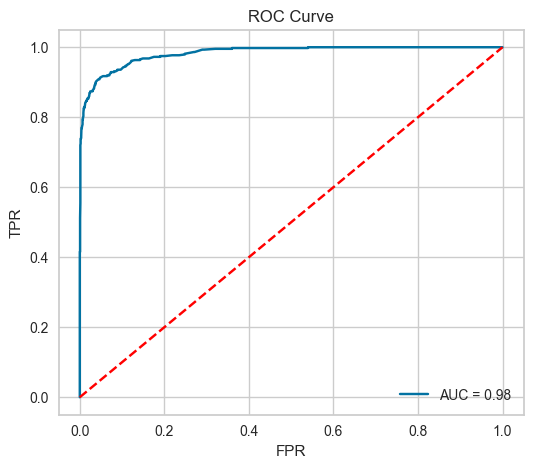

In [30]:
from sklearn.ensemble import RandomForestClassifier 

pipeline = Pipeline([('smote', SMOTE(random_state=42)),
                     ('scaler', StandardScaler()),
                     ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

model(X,y,pipeline)


### XGBoost
Among all the models evaluated, XGBoost achieved the highest test accuracy of 96.28%, demonstrating strong overall performance in classifying both fraudulent and non-fraudulent cases.

Based on a test dataset of 1,964 samples:

* Out of 436 actual fraud cases, the model correctly identified 390, achieving a recall of 89%.

* Out of 417 predicted fraud cases, 390 were correct, yielding a precision of 94%.

An AUC (Area Under the ROC Curve) of 0.99 indicates that the model is highly effective at distinguishing between the two classes, suggesting near-perfect separability between fraudulent and non-fraudulent transactions.

While the model performs exceptionally well, it is worth noting that the training accuracy was 99.90%, significantly higher than the test accuracy of 96.28%. This gap may suggest overfitting, where the model captures patterns specific to the training data that may not generalize to new, unseen data.

To address this, techniques such as regularization, cross-validation, or feature selection can be considered to improve the model’s generalization and reduce overfitting risk.

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1528
           1       0.94      0.89      0.91       436

    accuracy                           0.96      1964
   macro avg       0.95      0.94      0.95      1964
weighted avg       0.96      0.96      0.96      1964

Confusion Matrix: 
[[1501   27]
 [  46  390]]


Training accuracy: 0.9990
Test accuracy:     0.9628


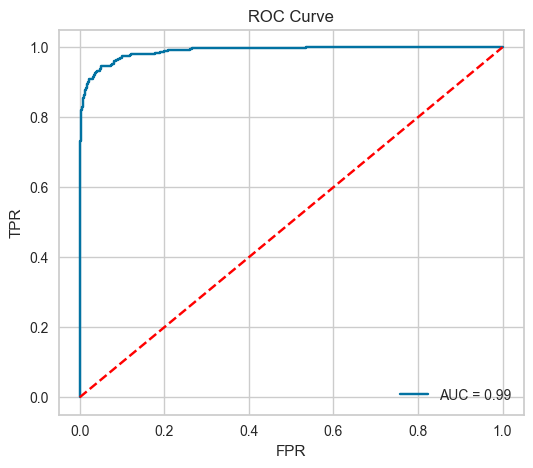

In [31]:
from xgboost import XGBClassifier

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()), 
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

model(X, y, pipeline)  

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier  # or your model

model = RandomForestClassifier()
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')  # use 'roc_auc' for AUC

print("Cross-Validation Accuracy Scores:", scores)
print("Mean CV Accuracy:", scores.mean())


Cross-Validation Accuracy Scores: [0.95977597 0.9623026  0.96383087 0.96586857 0.95924605]
Mean CV Accuracy: 0.9622048114144256
